<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/feature_engineering/1.data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


files = [
    'path_manager.py',
    'sklearn_utils.py',
    'sklearn_transformers.py'
]

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'
url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_transformers
import sklearn_utils

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils,
        sklearn_transformers
    ]
)

from path_manager import PathManager

from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import nan_statistics
from sklearn_utils import visualize_datasets_distributions

from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer

# Set up paths

In [5]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'


PREPROC_TRIAL = 3
MODELS_TRIAL = 2
COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'

Mounted at /content/gdrive


In [6]:
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

In [7]:
manager.setup_paths()

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Data/preproc_trial_3 already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_2 already exists


# 1. Frame the problem

- **Type of task?**
    - Supervised / Unsupervised / Reinforcement?
        - Supervised
    - Classification / Regression / Clustering / Novelty search?
        - Regression (univariate, multiple regression)
    - Batch learning / Online learning?
        - Batch learning

- **How company will benefit from task?**
    - **Predicting revenue (money) of a restaurang, to justify investment in building a new one in a given area**

- **Algorithms?**
    - SGD regressor, SVM, Random forest, FFNN, KNN regressor

- **Performance measure?**
    - RMSE
    - MAE if many outliers

- **What the current solution looks like?**
    - Human analysis



# 2. Check assumptions

- No serious assumptions. This competition needs indeed a regression output (values), but not categories or classes.

# 3. Download the data

In [8]:
train_df = pd.read_csv(manager.train_path, index_col='Id')
test_df = pd.read_csv(manager.test_path, index_col='Id')

In [9]:
train_df.head(1)
print(train_df.shape, test_df.shape)

(137, 42) (100000, 41)


# 4. Quick look at data structure

- Outliers and skew in the target variable (revenue)
- Approximately same range of numerical features
- No missing values

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 136
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open Date   137 non-null    object 
 1   City        137 non-null    object 
 2   City Group  137 non-null    object 
 3   Type        137 non-null    object 
 4   P1          137 non-null    int64  
 5   P2          137 non-null    float64
 6   P3          137 non-null    float64
 7   P4          137 non-null    float64
 8   P5          137 non-null    int64  
 9   P6          137 non-null    int64  
 10  P7          137 non-null    int64  
 11  P8          137 non-null    int64  
 12  P9          137 non-null    int64  
 13  P10         137 non-null    int64  
 14  P11         137 non-null    int64  
 15  P12         137 non-null    int64  
 16  P13         137 non-null    float64
 17  P14         137 non-null    int64  
 18  P15         137 non-null    int64  
 19  P16         137 non-null    i

In [ ]:
train_df.describe()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,5.489051,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,1.847561,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,5.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


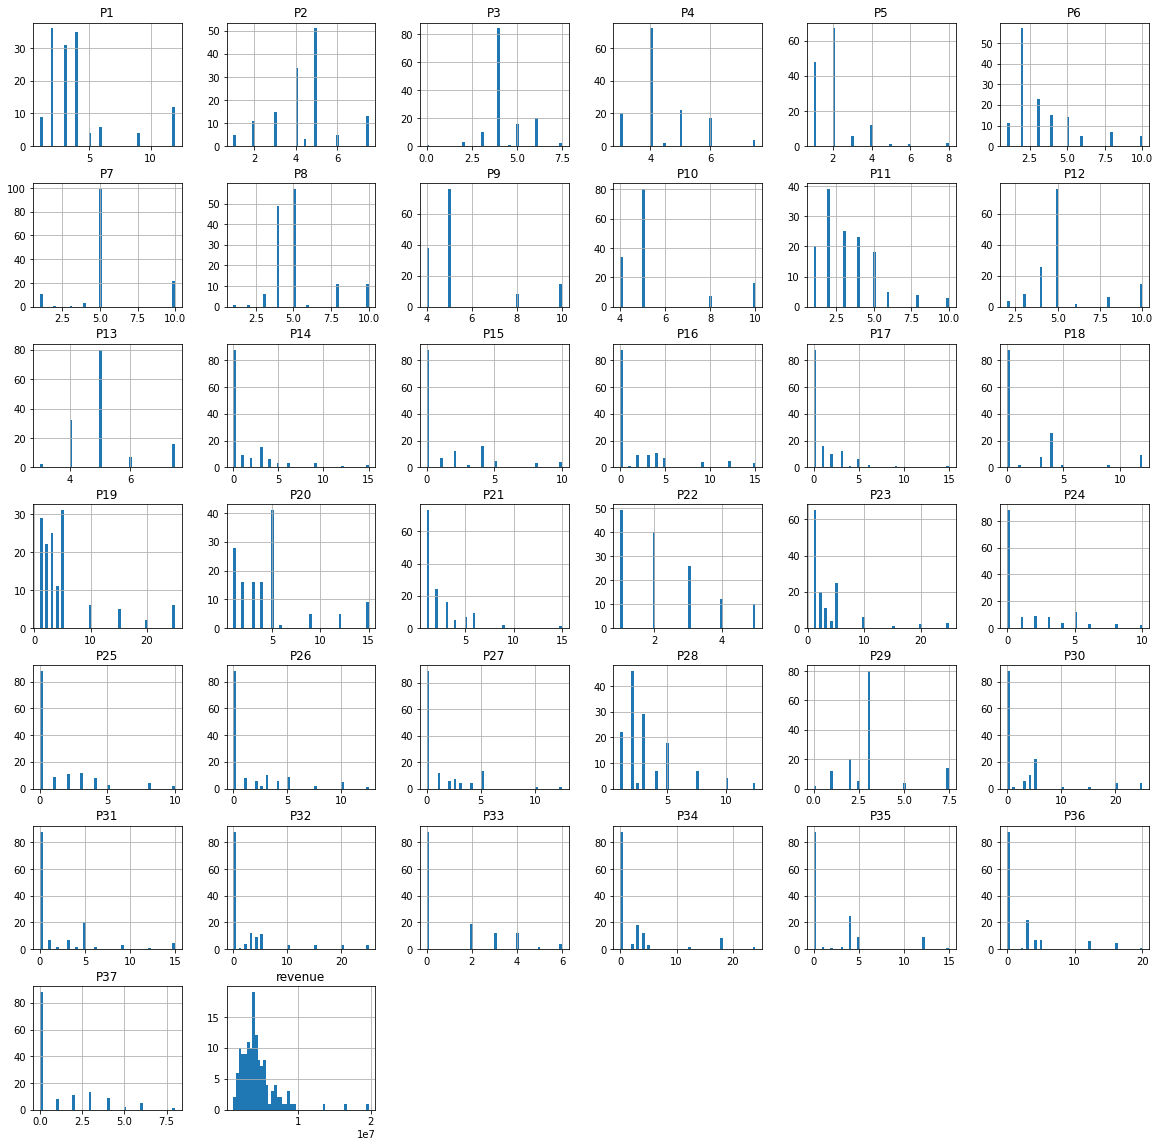

In [ ]:
_ = train_df.hist(bins=50, figsize = (20, 20))

# 5. Create test + trainval sets (remember stratified sampling)

In [10]:
TEST_PERCENTAGE = 0.15
RANDOM_STATE = 42

train_val_sample, test_sample = train_test_split(
    train_df,
    test_size = TEST_PERCENTAGE,
    random_state = RANDOM_STATE,
    # stratify = train_df['revenue'].values
)

Text(0, 0.5, 'Percentage')

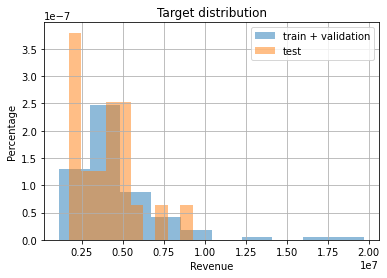

In [11]:
fig, ax = plt.subplots()

ax.hist(train_val_sample['revenue'], density=True, alpha=0.5)
ax.hist(test_sample['revenue'], density=True, alpha=0.5)

ax.legend(['train + validation', 'test'])
ax.grid()
ax.set_title('Target distribution')
ax.set_xlabel('Revenue')
ax.set_ylabel('Percentage')

# 6. Data exploration (from now on: work with trainval set)

- Heavy tail - might log-transform the data. Because many algorithms fail to detect patterns for data with heavy tails
- P28, P6, P17 - log transform
- Big cities contribute to larger revenue (City Group feature). Apply cat encoding, to enforce order
- One hot encoding for the restaurant type. We will not inflate the the dataset, as there are only 4 types of categories
- The majority of restaurants opened after 2007 (skewed). There is an upward trend - the later a restaurant is opened, the more revenue it gives. Replace text feature "Opening date" with numeric feature - year of opening
- Strong correlation with a new feature - population of the city

## Sample an exploration set

- Not necessary, dataset is of low size
- **At this step - make a copy of dataset for experiments (for safety)**

In [ ]:
exploration_df = train_val_sample.copy()

## Visualizations

### Target variable

(None, None)

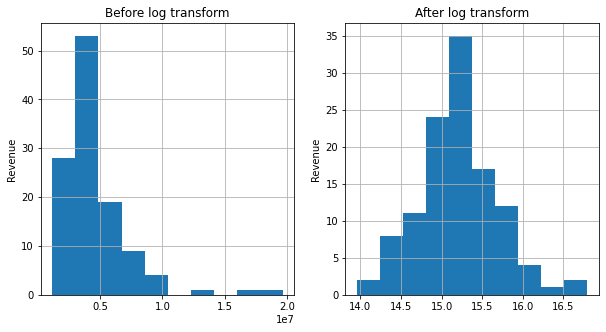

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].hist(exploration_df['revenue'])
ax[0].set_title('Before log transform')
ax[0].set_ylabel('Revenue')

ax[1].hist(np.log(exploration_df['revenue']))
ax[1].set_title('After log transform')
ax[1].set_ylabel('Revenue')

ax[0].grid(), ax[1].grid()

### Revenue by city

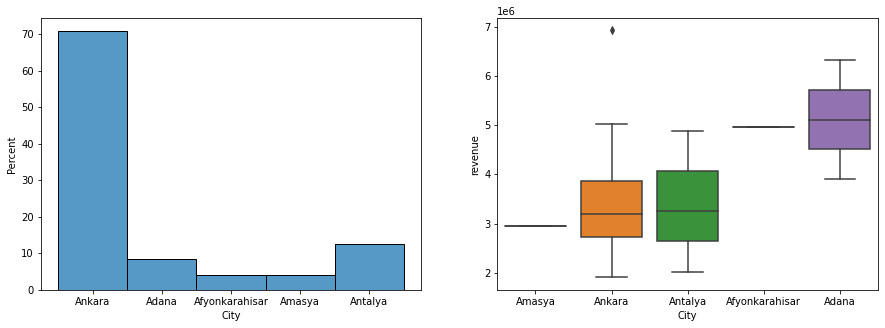

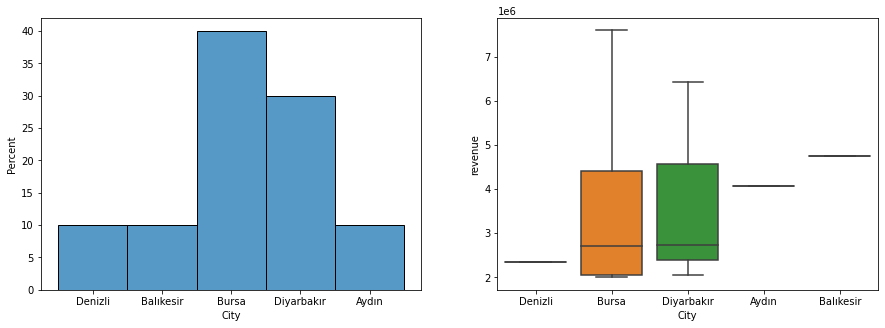

In [ ]:
counter = 0
available_cities = np.unique(exploration_df['City'])

boxplot_regression(
    df_=exploration_df.loc[np.isin(exploration_df['City'], available_cities[0:5]), :],
    cat_feature_='City',
    target_feature_='revenue'
)

boxplot_regression(
    df_=exploration_df.loc[np.isin(exploration_df['City'], available_cities[5:10]), :],
    cat_feature_='City',
    target_feature_='revenue'
)

### Restaurant type

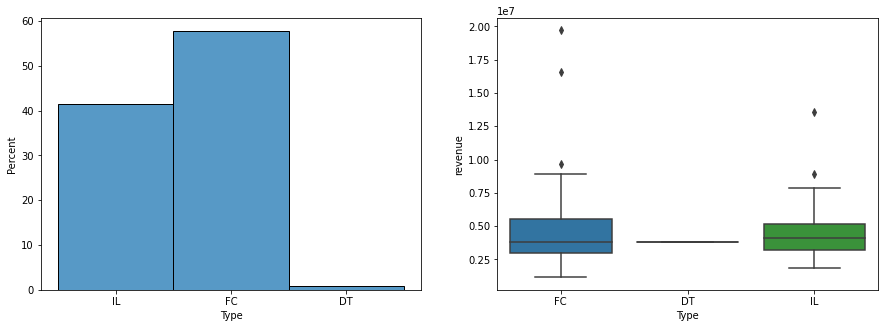

In [ ]:
exploration_df['Type'].value_counts()
boxplot_regression(
    df_=exploration_df, 
    cat_feature_='Type', 
    target_feature_='revenue'
)

### City type

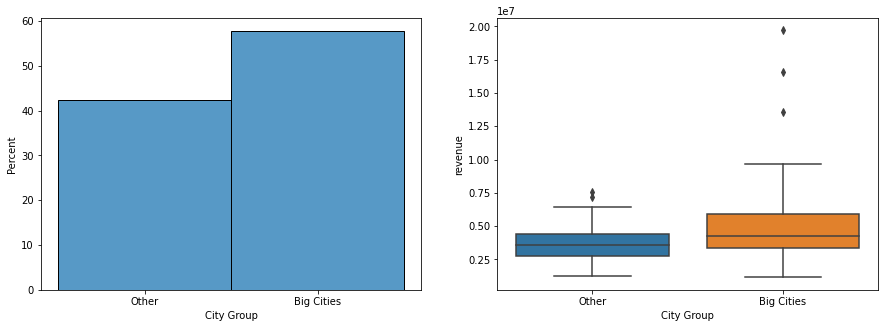

In [ ]:
boxplot_regression(exploration_df, 'City Group', 'revenue')

## Correlations & scatter matrix

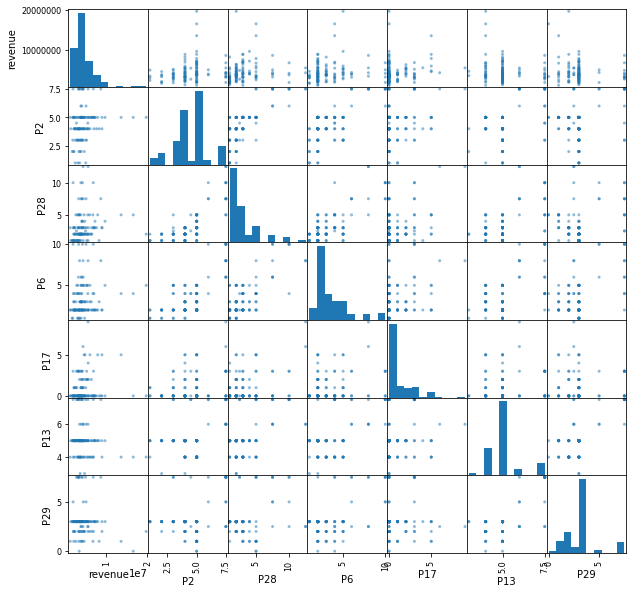

In [ ]:
attributes = get_correlated_attributes(exploration_df, 'revenue', 0.12).index
_ = scatter_matrix(exploration_df[attributes], figsize=(10, 10))

## Looking for interesting features

### Experiment with attribute combinations

- Not a lot of attributes to combine (unline Housing prices tasks, here we cannot combint P-features). I focus on feature engineering component

### Year of opening

In [ ]:
dates = exploration_df['Open Date'].values
years = [int(date.split('/')[-1]) for date in dates]
years[:5]

[2009, 2007, 2008, 2009, 2007]

In [ ]:
exploration_df['open_year'] = years

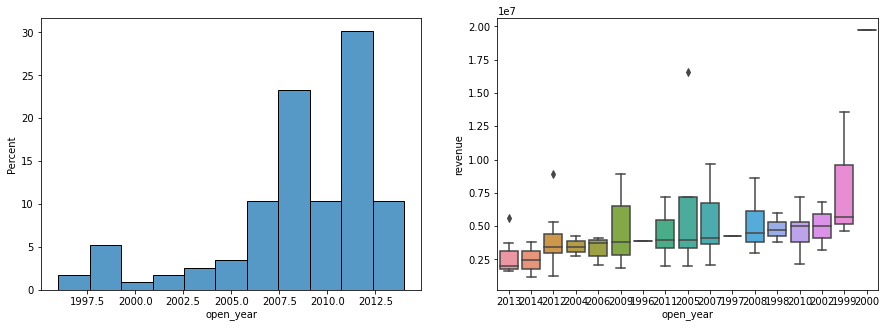

In [ ]:
boxplot_regression(exploration_df, 'open_year', 'revenue')

### Population

In [ ]:
def write_population(city):
    populations = {
        'Gaziantep': 2069000,
        'Ankara': 5663000,
        'İstanbul': 15460000,
        'İzmir'  : 4367000,
        'Kocaeli'  : 2033441,
        'Osmaniye'  : 219339,
        'Kastamonu'  : 128537,
        'Eskişehir'  : 887475,
        'Denizli'  : 1028000,
        'Balıkesir'  : 1229000,
        'Sakarya'  : 567000,
        'Tekirdağ'  : 204001,
        'Bursa'  : 2055000,
        'Kayseri'  : 1062000,
        'Muğla'  : 1000773,
        'Edirne'  : 165979,
        'Samsun'  : 605319,
        'Karabük'  : 248014,
        'Adana'  : 1769000,
        'Afyonkarahisar'  : 744179,
        'Tokat'  : 612646,
        'Amasya'  : 91874,
        'Diyarbakır'   : 1783000,
        'Kütahya'  : 248054,
        'Antalya'   : 1319000,
        'Aydın'   : 1134031,
        'Şanlıurfa'  : 2031000,
        'Kırklareli'  : 88956,
        'Isparta'   : 198385,
        'Uşak'  :  500000,
        'Elazığ'  : 541258
    }
    
    
    assert city in populations.keys()
    return populations[city]

exploration_df['population'] = exploration_df['City'].apply(
    lambda row: write_population(row))

In [ ]:
get_correlated_attributes(exploration_df, 'revenue', 0.12)

revenue       1.000000
population    0.363098
P2            0.191189
P28           0.150818
P6            0.136381
P17           0.133384
P13          -0.126957
P29          -0.127254
open_year    -0.318152
Name: revenue, dtype: float64

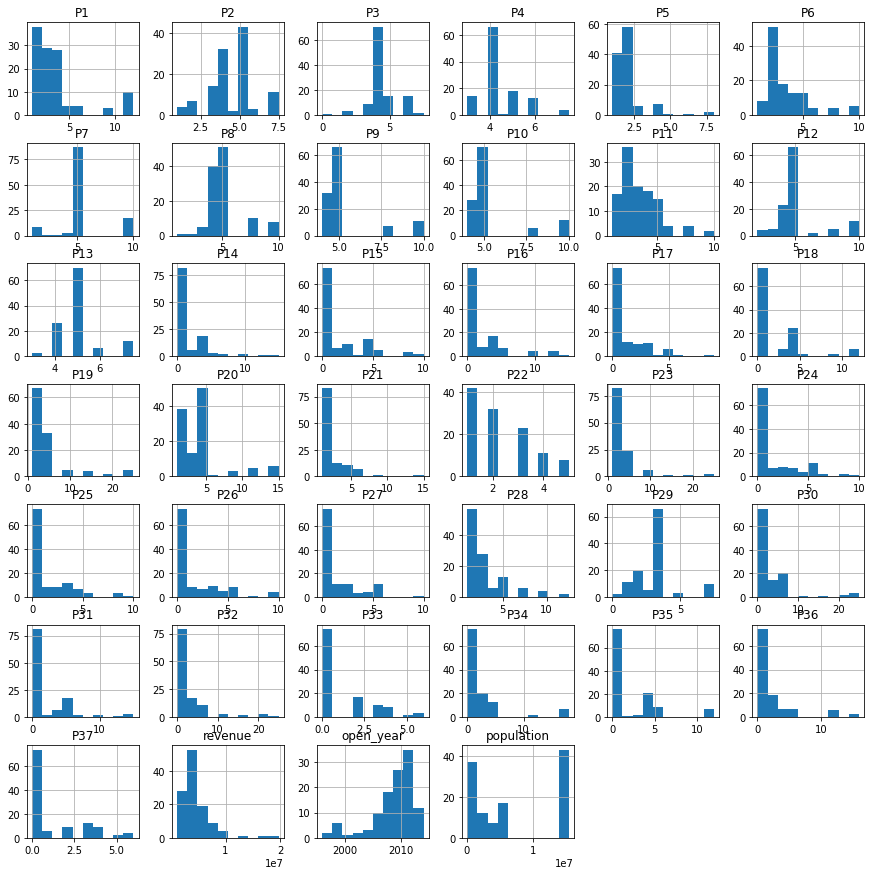

In [ ]:
_ = exploration_df.hist(figsize=(15, 15))

### City area

In [ ]:
def write_area(city):
    # in km2
    # urban area
    areas = {
        'Gaziantep': 6819,
        'Ankara': 2516,
        'İstanbul': 5343,
        'İzmir': 3159,
        'Kocaeli': 3626,
        'Osmaniye': 746,
        'Kastamonu': 1834,
        'Eskişehir': 2678,
        'Denizli': 798,
        'Balıkesir': 1453.97,
        'Sakarya': 4821,
        'Tekirdağ': 1111.53,
        'Bursa': 1036,
        'Kayseri': 6430,
        'Muğla': 1582,
        'Edirne': 844,
        'Samsun': 1055,
        'Karabük': 760,
        'Adana': 2280,
        'Afyonkarahisar': 14.23,
        'Tokat': 9.958,
        'Amasya': 1729.69,
        'Diyarbakır': 15355,
        'Kütahya': 2484.16,
        'Antalya': 1417,
        'Aydın': 627.2,
        'Şanlıurfa': 18584,
        'Kırklareli': 6550,
        'Isparta': 8993,
        'Uşak':  5341,
        'Elazığ': 2211.07,
            
        'Bolu': 1524.37,
        'Konya': 6600,
        'Trabzon': 188.85,
        'Niğde': 2302.99,
        'Aksaray': 4589,
        'Artvin': 1084.74,
        'Batman': 563.59,
        'Bilecik': 840.47,
        'Düzce': 739.13,
        'Erzincan': 1622.08,
        'Erzurum': None,
        'Giresun': 317,
        'Hatay': 5524,
        'Kahramanmaraş': None,
        'Kars': 1804,
        'Kırıkkale': 318.07,
        'Kırşehir': 1677.67,
        'Malatya': 822.16,
        'Manisa': 13339,
        'Mardin': 8891,
        'Mersin': 1590,
        'Nevşehir': 535,
        'Ordu': 586,
        'Rize': 250.14,
        'Siirt': 284,
        'Sivas': 2768,
        'Tanımsız': None,  # ??? not in google
        'Yalova': 166.85,
        'Zonguldak': 632.98,
        'Çanakkale': 937.82,
        'Çankırı': 1347.05,
        'Çorum': 2276.81
    }
    
    assert city in areas.keys()
    return areas[city]


In [ ]:
# exploration_df['population'] = exploration_df['City'].apply(
#     lambda row: write_population(row))

exploration_df['City area'] = exploration_df['City'].apply(
    lambda row: write_area(row)
)

revenue       1.000000
population    0.363098
P2            0.191189
P28           0.150818
P6            0.136381
P17           0.133384
City area     0.122537
P13          -0.126957
P29          -0.127254
open_year    -0.318152
Name: revenue, dtype: float64


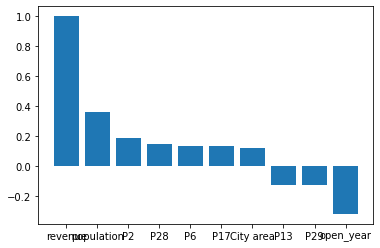

In [ ]:
corr_series = get_correlated_attributes(exploration_df, 'revenue', 0.12)
plt.bar(
    # np.arange(len(corr_series.values)), 
    corr_series.index,
    corr_series.values
)
print(corr_series)

# 7. Data preparation

## Check missing and infinite values

In [ ]:
nan_statistics(train_val_sample), nan_statistics(test_sample)

Col -- Nan percentage
Col -- Nan percentage


({}, {})

## Text and categorical attributes

In [ ]:
def get_categorical_columns(df_):
    return df_.dtypes[df_.dtypes == 'object']

cat_columns = get_categorical_columns(train_val_sample)
cat_columns

Open Date     object
City          object
City Group    object
Type          object
dtype: object

In [ ]:
train_val_sample['City Group'].value_counts()

Big Cities    67
Other         49
Name: City Group, dtype: int64

### City Group


In [ ]:
# Apply ordinal encoding. 
# Such that big cities were ranked higher, than other
# areas.

enc = OrdinalEncoder(categories = [['Other', 'Big Cities']])
enc.fit(train_val_sample[['City Group']])

OrdinalEncoder(categories=[['Other', 'Big Cities']])

### Type (of restaurant)

In [ ]:
one_hot_enc = OneHotEncoder()
one_hot_enc.fit(train_val_sample[['Type']])

OneHotEncoder()

In [ ]:
res = one_hot_enc.transform(train_val_sample[['Type']])
res

<116x3 sparse matrix of type '<class 'numpy.float64'>'
	with 116 stored elements in Compressed Sparse Row format>

### City 

- Dropping that column

In [ ]:
dropper = ColumnDropper(
    columns_to_drop = ['City']
)

res = dropper.fit_transform(train_val_sample)
assert not 'City' in res.columns
assert 'City' in train_val_sample.columns

# Engineer new features

In [12]:
from sklearn.base import TransformerMixin, BaseEstimator


class PopulationAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.populations = {
            'Gaziantep': 2069000,
            'Ankara': 5663000,
            'İstanbul': 15460000,
            'İzmir': 4367000,
            'Kocaeli': 2033441,
            'Osmaniye': 219339,
            'Kastamonu': 128537,
            'Eskişehir': 887475,
            'Denizli': 1028000,
            'Balıkesir': 1229000,
            'Sakarya': 567000,
            'Tekirdağ': 204001,
            'Bursa': 2055000,
            'Kayseri': 1062000,
            'Muğla': 1000773,
            'Edirne': 165979,
            'Samsun': 605319,
            'Karabük': 248014,
            'Adana': 1769000,
            'Afyonkarahisar': 744179,
            'Tokat': 612646,
            'Amasya': 91874,
            'Diyarbakır': 1783000,
            'Kütahya': 248054,
            'Antalya': 1319000,
            'Aydın': 1134031,
            'Şanlıurfa': 2031000,
            'Kırklareli': 88956,
            'Isparta': 198385,
            'Uşak':  500000,
            'Elazığ': 541258,
            'Bolu': 131264,
            'Konya': 2161000,
            'Trabzon': 312060,
            'Niğde': 341412,
            'Aksaray': 416317,
            'Artvin': 25771,
            'Batman': 348963,
            'Bilecik': 64531,
            'Düzce': 135557,
            'Erzincan': 236034,
            'Erzurum': 767848,
            'Giresun': 100712,
            'Hatay': 1670712,
            'Kahramanmaraş': 547000,
            'Kars': 78100,
            'Kırıkkale': 192473,
            'Kırşehir': 114244,
            'Malatya': 512000,
            'Manisa': 356702,
            'Mardin': 809719,
            'Mersin': 955106,
            'Nevşehir': 303010,
            'Ordu': 229214,
            'Rize': 344359,
            'Siirt': 135350,
            'Sivas': 359219,
            'Tanımsız': 500000,  # ??? not in google
            'Yalova': 121479,
            'Zonguldak': 213544,
            'Çanakkale': 328736,
            'Çankırı': 216362,
            'Çorum': 237000
        }
        self.max_population = np.max(list(self.populations.values()))
        self.min_population = np.min(list(self.populations.values()))

    def fit(self, X, y=None):
        return self

    def write_population(self, city):
        assert city in self.populations.keys(), print(city)

        return self.populations[city]

        # return (self.populations[city] - self.min_population)\
        #     / (self.max_population - self.min_population)

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['population'] = X['City'].apply(
            lambda row: self.write_population(row)
        )
        return transformed_df


pep8(_ih)

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class AreaAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.areas = {
            'Gaziantep': 6819,
            'Ankara': 2516,
            'İstanbul': 5343,
            'İzmir': 3159,
            'Kocaeli': 3626,
            'Osmaniye': 746,
            'Kastamonu': 1834,
            'Eskişehir': 2678,
            'Denizli': 798,
            'Balıkesir': 1453.97,
            'Sakarya': 4821,
            'Tekirdağ': 1111.53,
            'Bursa': 1036,
            'Kayseri': 6430,
            'Muğla': 1582,
            'Edirne': 844,
            'Samsun': 1055,
            'Karabük': 760,
            'Adana': 2280,
            'Afyonkarahisar': 14.23,
            'Tokat': 9.958,
            'Amasya': 1729.69,
            'Diyarbakır': 15355,
            'Kütahya': 2484.16,
            'Antalya': 1417,
            'Aydın': 627.2,
            'Şanlıurfa': 18584,
            'Kırklareli': 6550,
            'Isparta': 8993,
            'Uşak':  5341,
            'Elazığ': 2211.07,

            'Bolu': 1524.37,
            'Konya': 6600,
            'Trabzon': 188.85,
            'Niğde': 2302.99,
            'Aksaray': 4589,
            'Artvin': 1084.74,
            'Batman': 563.59,
            'Bilecik': 840.47,
            'Düzce': 739.13,
            'Erzincan': 1622.08,
            'Erzurum': None,
            'Giresun': 317,
            'Hatay': 5524,
            'Kahramanmaraş': None,
            'Kars': 1804,
            'Kırıkkale': 318.07,
            'Kırşehir': 1677.67,
            'Malatya': 822.16,
            'Manisa': 13339,
            'Mardin': 8891,
            'Mersin': 1590,
            'Nevşehir': 535,
            'Ordu': 586,
            'Rize': 250.14,
            'Siirt': 284,
            'Sivas': 2768,
            'Tanımsız': None,  # ??? not in google
            'Yalova': 166.85,
            'Zonguldak': 632.98,
            'Çanakkale': 937.82,
            'Çankırı': 1347.05,
            'Çorum': 2276.81
    }
    
    def fit(self, X, y=None):
        return self
    
    def assign_area(self, city):
        assert city in self.areas.keys()
        return self.areas[city]

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['city_area'] = transformed_df['City'].apply(
            lambda city: self.assign_area(city)
        )
        return transformed_df

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin


class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self._column_index = 0  # column_index

    def fit(self, X, y=None):
        return self

    def get_year(self, date_):
        return int(date_.split('/')[-1])

    def transform(self, X, y=None):
        dates = X.loc[:, 'Open Date'].values
        numeric_years = np.array(
            list(map(self.get_year, dates)), dtype=np.float64
        )

        res_df = X.copy()
        res_df['Open Date'] = (numeric_years)
        # X[:, self._column_index] = res
        return res_df


pep8(_ih)

In [15]:
from sklearn.base import TransformerMixin, BaseEstimator


class HugeAreaAndPopulationAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()

        X_transformed['huge_population'] = np.array(
            X_transformed['population'] > 1e7,
            dtype=np.int64
        )

        X_transformed['huge_city_area'] = np.array(
            X_transformed['city_area'] > 10000,
            dtype=np.int64
        )

        return X_transformed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c93fb53d0>,
      dtype=object)

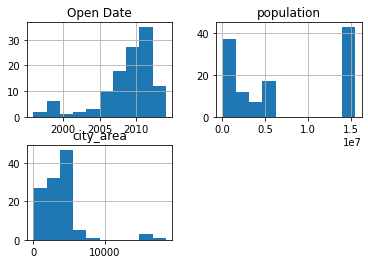

In [ ]:
train_val_sample[['Open Date', 'population', 'city_area']].hist()

In [16]:
transformers = [
    AreaAdder(),
    PopulationAdder(),
    DateTransformer(),
    HugeAreaAndPopulationAdder()
]


for t in transformers:
    train_val_sample = t.fit_transform(train_val_sample)
    test_sample = t.transform(test_sample)
    test_df = t.transform(test_df)

# Define columns for pipeline

In [52]:
assert (train_val_sample.columns == test_sample.columns).all()

num_cols = train_val_sample.columns[
    np.isin(train_val_sample.dtypes, ['float64', 'int64'])
]

num_cols = num_cols.drop('revenue')

cat_cols = train_val_sample.columns[
    train_val_sample.dtypes == 'object'
]

target_cols = ['revenue']

print(cat_cols)
print(num_cols)
print(target_cols)

Index(['City', 'City Group', 'Type'], dtype='object')
Index(['Open Date', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9',
       'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19',
       'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29',
       'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'city_area',
       'population', 'huge_population', 'huge_city_area'],
      dtype='object')
['revenue']


## Creating pipeline

In [59]:
num_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', MinMaxScaler())
    ]
)

city_group_pipeline = Pipeline(
    [
        ('encoder', OrdinalEncoder(categories=[['Other', 'Big Cities']]))  
    ]
)

type_pipeline = Pipeline(
    [
        ('encoder', OneHotEncoder(categories=[['IL', 'FC', 'DT', 'MB']]))
    ]
)

city_pipeline = Pipeline(
    [
        ('drop', ColumnDropper(['City']))
    ]
)



In [60]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [
        ('numeric_data', num_pipeline, num_cols),
        ('city_group', city_group_pipeline, ['City Group']),
        ('type', type_pipeline, ['Type']),
        ('drop', city_pipeline, ['City'])
    ],
    remainder='passthrough'
)

In [61]:
# These are the subsets of the training set
trainval_sample_processed = preprocessor.fit_transform(
    train_val_sample
)
test_sample_processed = preprocessor.transform(test_sample)

In [62]:
# This is the kaggle test set
test_df['revenue'] = np.ones(test_df.shape[0]) # to avoid bug. because no such column
test_processed = preprocessor.transform(
    test_df
)

In [67]:
trainval_sample_processed.dtype

dtype('float64')

## Log transform to target

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin


class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X[:, -1] = np.log(X[:, -1])
        return X

log_transformer = LogTransformer()

trainval_sample_processed = log_transformer.fit_transform(
    trainval_sample_processed
)

In [75]:
test_sample_processed = log_transformer.transform(
    test_sample_processed
)

In [77]:
test_processed = log_transformer.transform(
    test_processed
)

# Drop unnecessary columns

In [58]:
# Already dropped in the 'drop' step above

array(['1', '2', '3.0', 'abc'], dtype='<U32')

# Saving processed data

In [80]:
manager.save_to_csv(
    array_=trainval_sample_processed,
    path_=manager.data_trial_path,
    file_name_='trainval_sample_processed.csv'
)

In [81]:
manager.save_to_csv(
    array_=test_sample_processed,
    path_=manager.data_trial_path,
    file_name_='test_sample_processed.csv'
)

In [82]:
manager.save_to_csv(
    array_=test_processed,
    path_=manager.data_trial_path,
    file_name_='test_processed.csv'
)

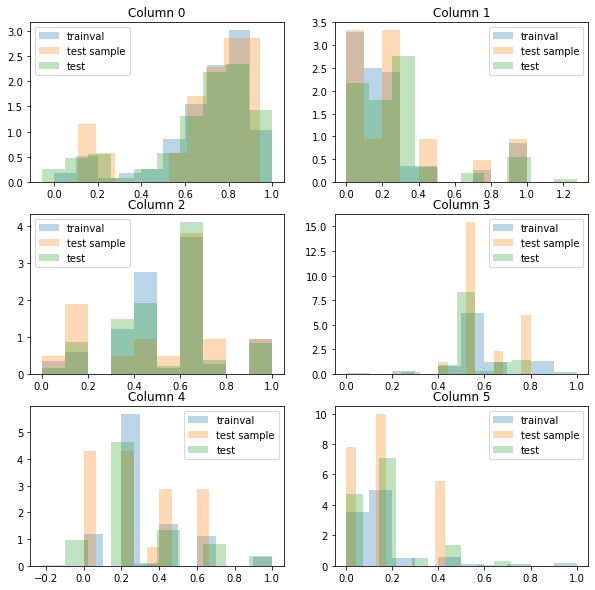

In [71]:
visualize_datasets_distributions(
    {
        'trainval': pd.DataFrame(trainval_sample_processed),
        'test sample': pd.DataFrame(test_sample_processed),
        'test': pd.DataFrame(test_processed)
    },
    column_numbers_ = range(5),
    grid_width_=2
)